## Northbound detectors are known to have an issue where values below a certain threshold are reported as zero

**Approach:**

1. Analyze distribution of wait times to find threshold at all crossings, lanes and directions
2. Investigate ways to impute erroneous zero values

In [223]:
from dbhelper import PgDB, get_crossings, pd_query
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import threading

In [117]:
crossings = get_crossings()

In [172]:
crossings

,id,location_id,lane_id,direction_id,location_name,lane_name,direction_name
0,15,136,0,0,Lynden,Car,Northbound
1,16,136,0,1,Lynden,Car,Southbound
2,17,136,4,0,Lynden,Truck,Northbound
3,18,136,4,1,Lynden,Truck,Southbound
4,8,135,2,0,Pacific Highway,Bus,Northbound
5,7,135,2,1,Pacific Highway,Bus,Southbound
6,6,135,0,0,Pacific Highway,Car,Northbound
7,5,135,0,1,Pacific Highway,Car,Southbound
8,10,135,3,0,Pacific Highway,Fast,Northbound
9,9,135,3,1,Pacific Highway,Fast,Southbound


In [73]:
query = '''
        select
            waittime,
            count(waittime) as wt
        from crossingdata_denorm
        where location_name = '%s'
            and direction_name = '%s'
            and lane_name = '%s'
            and valid = 1
            and waittime > 0
        group by waittime
        '''

jobs = []
result = [0 for x in range(len(crossings))]

for i, xing in enumerate(crossings):
    vals = (xing['location_name'], xing['direction_name'], xing['lane_name'])
    t = threading.Thread(target=query_threaded, args=(query, vals, result, i))
    jobs.append(t)
    t.start()
    
for t in jobs:
    t.join()

In [76]:
for xing, res in zip(crossings, result):
    print '-'.join([xing['location_name'], xing['direction_name'], xing['lane_name']])
    print res[:20]

Lynden-Northbound-Car
[[    1  2659]
 [    2  4906]
 [    3 43515]
 [    4 50151]
 [    5 20737]
 [    6 15097]
 [    7 11405]
 [    8 11331]
 [    9 10749]
 [   10 12849]
 [   11 11588]
 [   12  9554]
 [   13  9394]
 [   14  8425]
 [   15  8149]
 [   16  6090]
 [   17  9524]
 [   18  5368]
 [   19  4875]
 [   20  4283]]
Lynden-Southbound-Car
[[    1 48865]
 [    2 20428]
 [    3 18474]
 [    4 20603]
 [    5 12190]
 [    6  8090]
 [    7  8067]
 [    8  6563]
 [    9  4471]
 [   10  3187]
 [   11  3239]
 [   12  3646]
 [   13  3488]
 [   14  3188]
 [   15  2647]
 [   16  2493]
 [   17  2315]
 [   18  2182]
 [   19  2082]
 [   20  1811]]
Lynden-Northbound-Truck
[]
Lynden-Southbound-Truck
[]
Pacific Highway-Northbound-Bus
[]
Pacific Highway-Southbound-Bus
[[    1 16068]
 [    2  2990]
 [    3  2183]
 [    4  2745]
 [    5  6319]
 [    6  1861]
 [    7  1465]
 [    8  1719]
 [    9  3320]
 [   10  2886]
 [   11  3324]
 [   12  1009]
 [   13   535]
 [   14   510]
 [   15   557]
 [   16   

### Data is showing waittimes below 10 for all crossings
Investigate by year

In [100]:
query = '''
        select
            EXTRACT(YEAR FROM date) as year,
            waittime,
            count(waittime) as wt
        from crossingdata_denorm
        where location_name = '%s'
            and direction_name = '%s'
            and lane_name = '%s'
            and valid = 1
        group by EXTRACT(YEAR FROM date), waittime
        order by EXTRACT(YEAR FROM date), waittime
        '''

jobs = []
res2 = [0 for x in range(len(crossings))]

for i, xing in enumerate(crossings):
    vals = (xing['location_name'], xing['direction_name'], xing['lane_name'])
    t = threading.Thread(target=pd_query, args=(query, vals, res2, i))
    jobs.append(t)
    t.start()
    
for t in jobs:
    t.join()

In [133]:
res2[14].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1159
Data columns (total 3 columns):
year        1160 non-null int64
waittime    1153 non-null float64
wt          1160 non-null int64
dtypes: float64(1), int64(2)
memory usage: 36.2 KB


In [213]:
def plot_waittimes(wt_dist):
    plt.figure(figsize=(12,6))
    for i, year in enumerate(wt_dist.columns.values):
        plt.subplot(3, 3, i+1)
        plt.title(year)
        plt.bar(wt_dist.index, wt_dist[year])

    plt.tight_layout()
    plt.show()

Lynden - Northbound - Car


/Users/jng/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


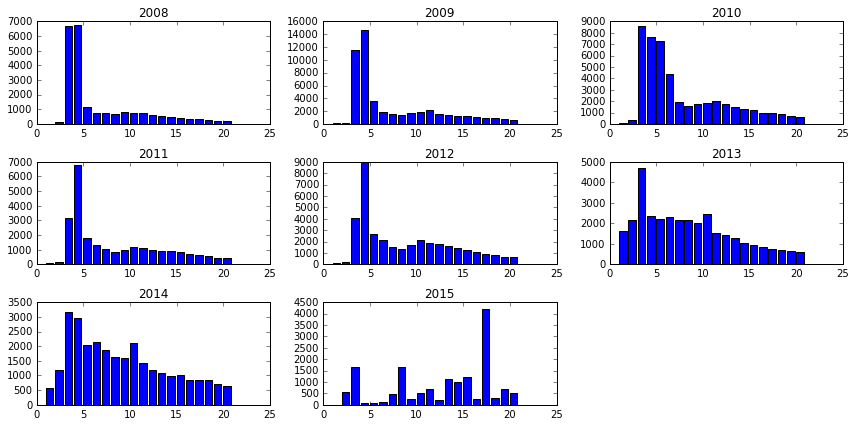

Lynden - Southbound - Car


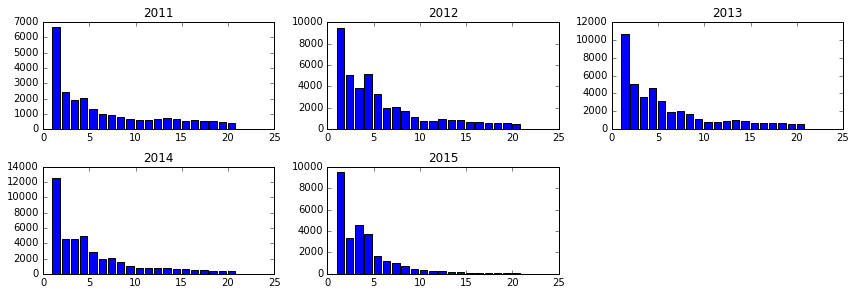

Pacific Highway - Southbound - Bus


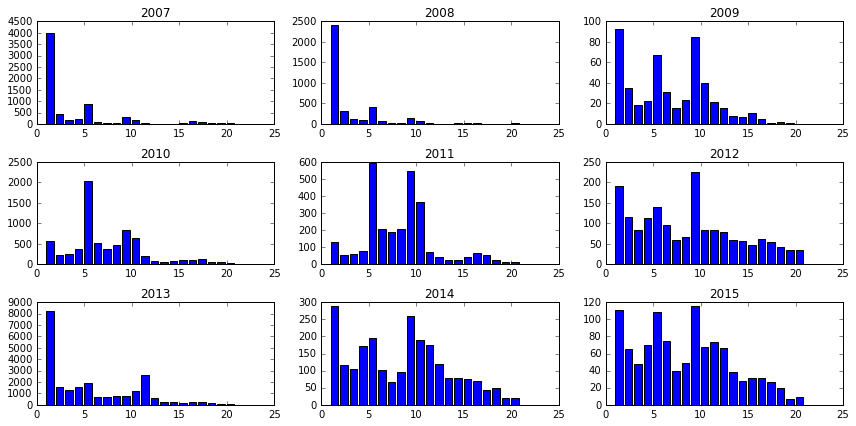

Pacific Highway - Northbound - Car


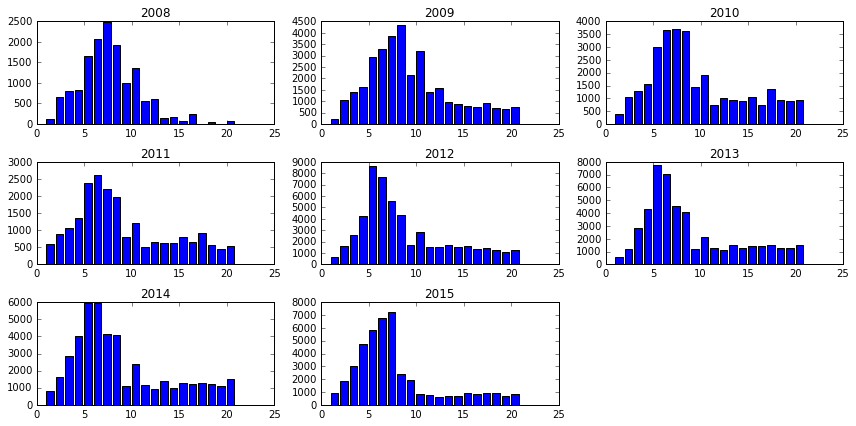

Pacific Highway - Southbound - Car


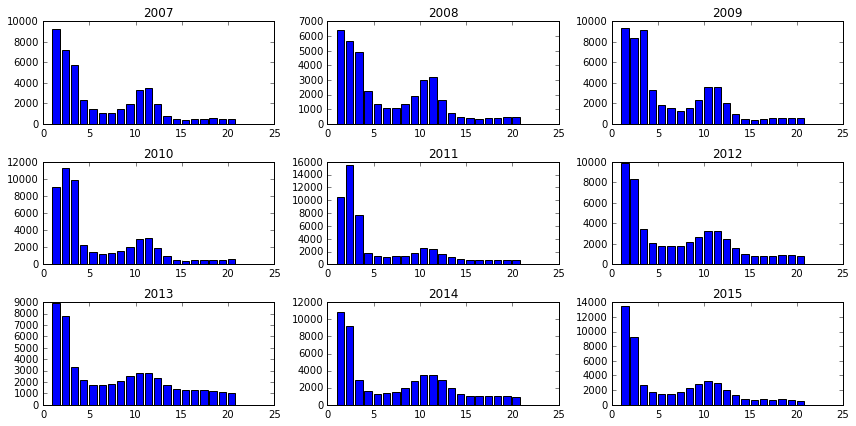

Pacific Highway - Northbound - Fast


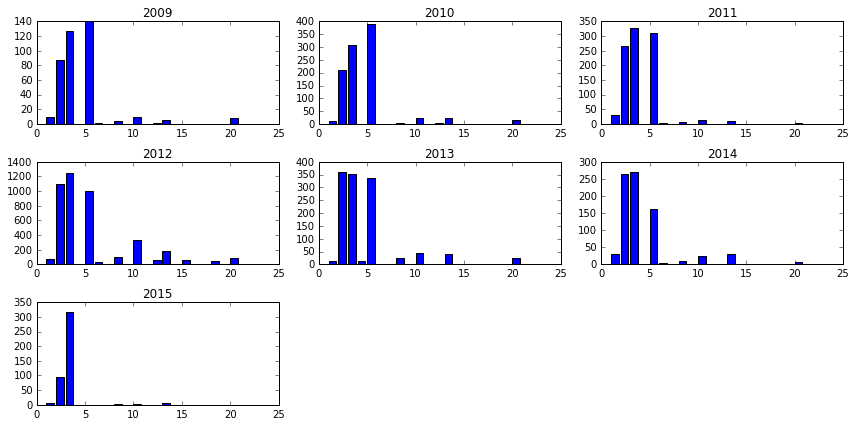

Pacific Highway - Southbound - Fast


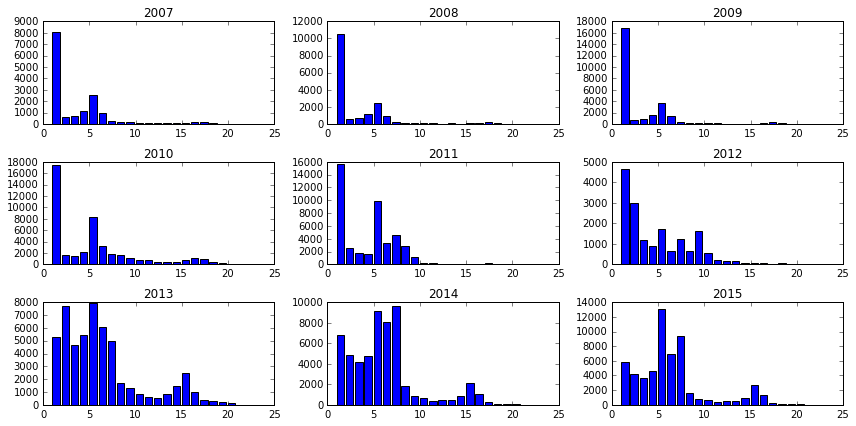

Pacific Highway - Northbound - Nexus


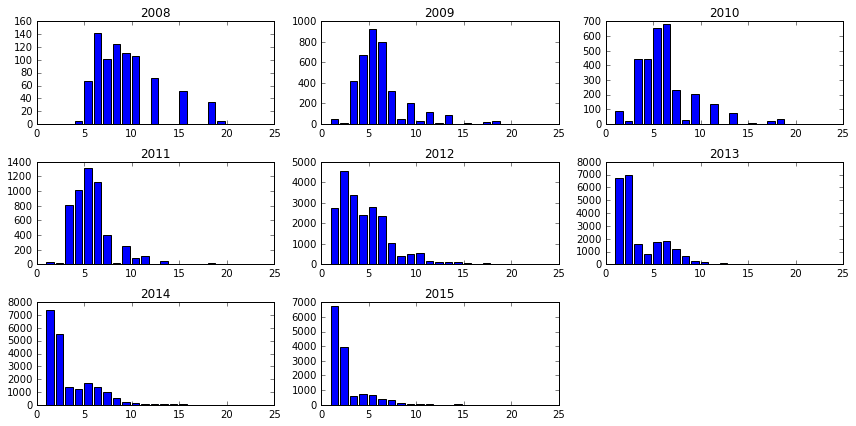

Pacific Highway - Southbound - Nexus


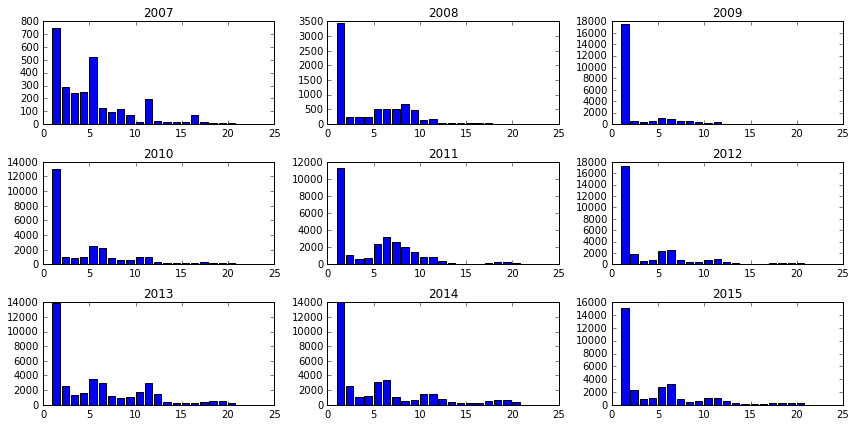

Pacific Highway - Northbound - Truck


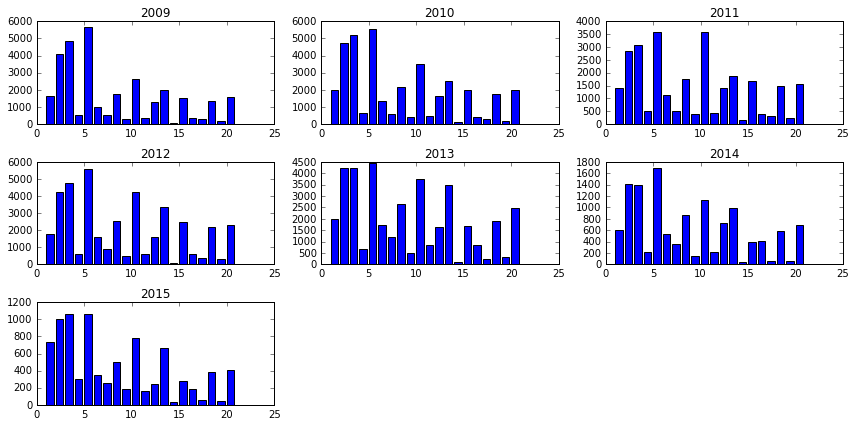

Pacific Highway - Southbound - Truck


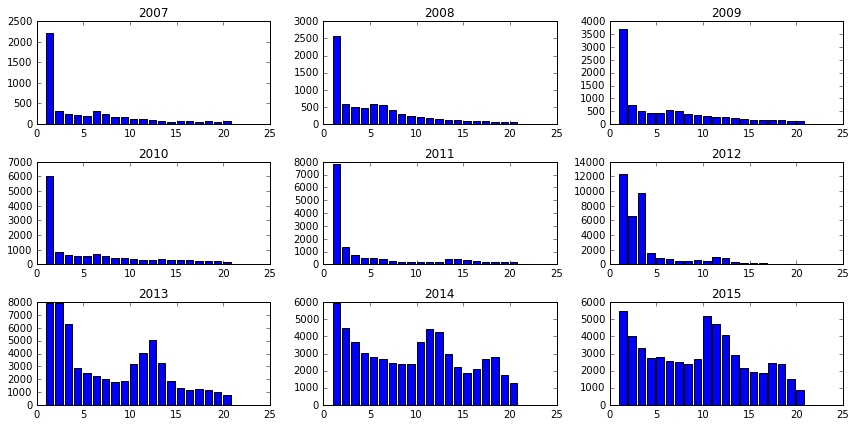

Peace Arch - Northbound - Car


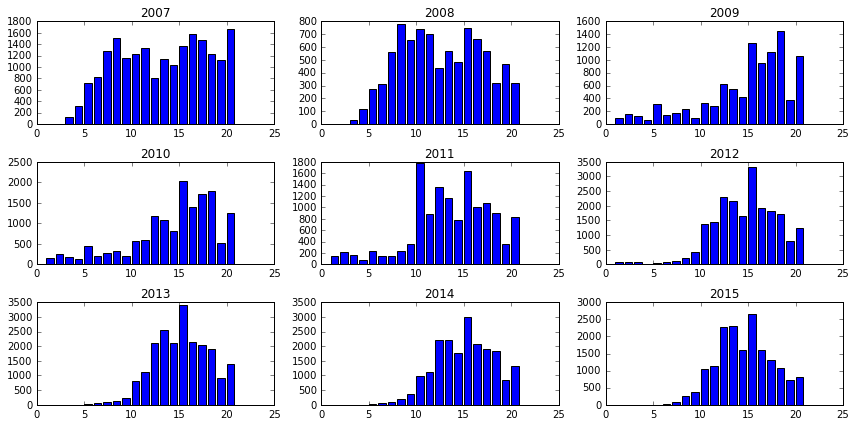

Peace Arch - Southbound - Car


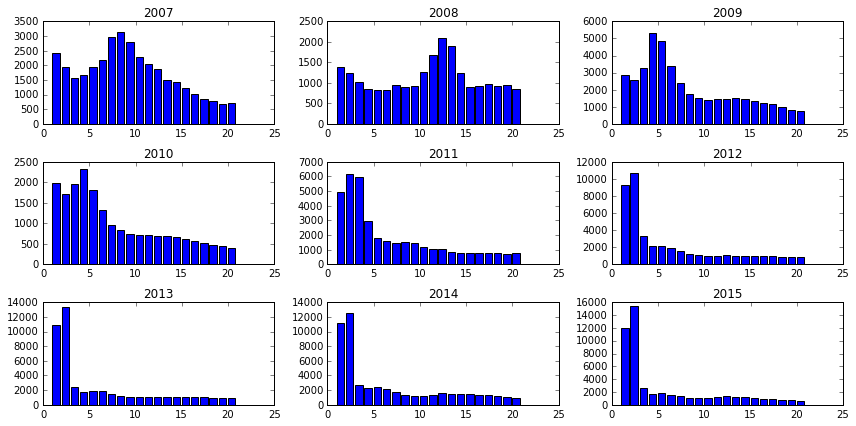

Peace Arch - Northbound - Nexus


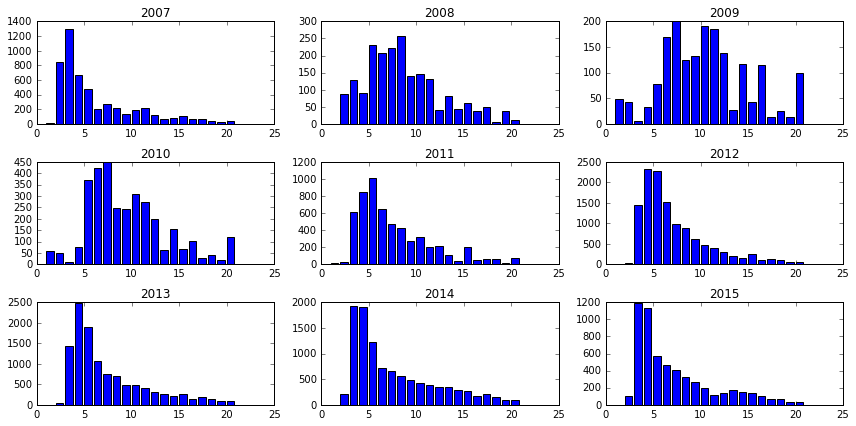

Peace Arch - Southbound - Nexus


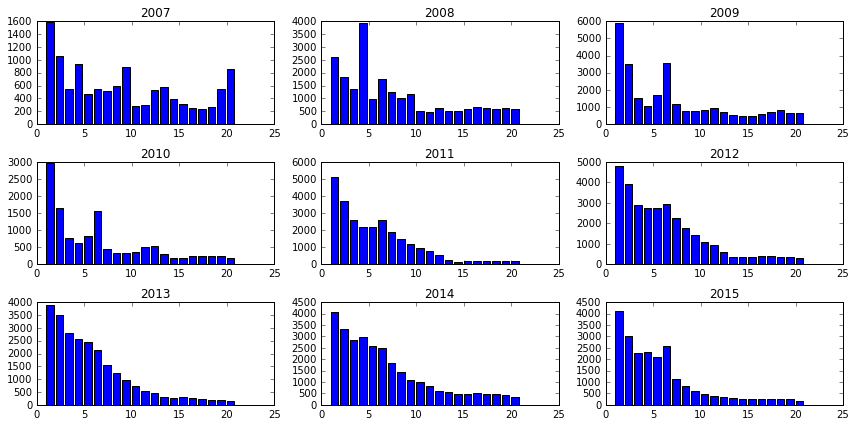

Sumas - Northbound - Car


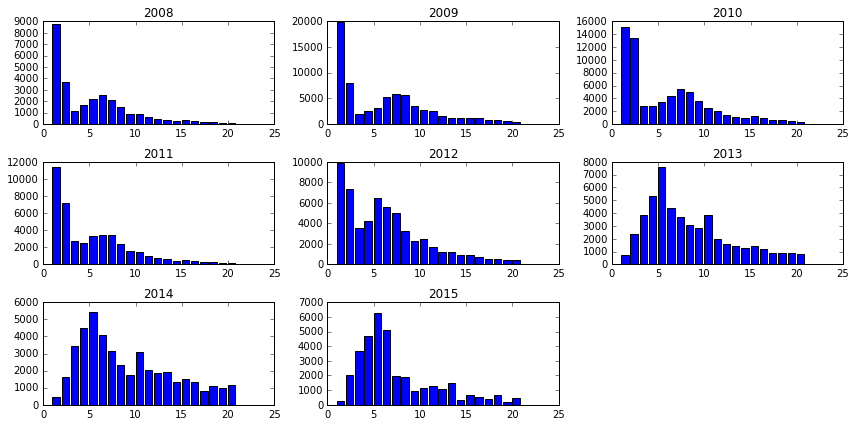

Sumas - Southbound - Car


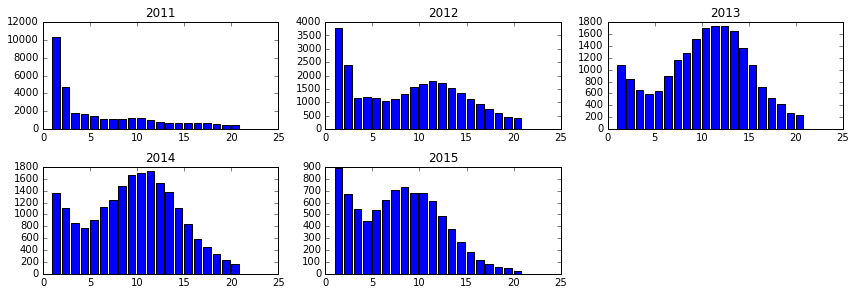

In [214]:
for i, res in enumerate(res2):
    res = res[~res.waittime.isnull()]
    res.year = res.year.astype(int)
    if len(res) > 0:
        xing = crossings.ix[i]

        print ' - '.join([xing['location_name'], xing['direction_name'], xing['lane_name']])  
        plot_waittimes(res.pivot(index='waittime', columns='year', values='wt').fillna(0)[1:20])

## Conclusions

Northbound data will need to be imputed to account for detector failures for low wait times.  Low wait time threshold varies by location and lane.

| Location| Dir | Lane | Notes                                                        |
|---------|---|-------|---------------------------------------------------------------|
| Lynden  | S | Car   | Unreliable below 3                                            |
| Lynden  | S | Car   | OK                                                            |
| Pacific | S | Bus   | OK, but strange spikes at 1, 5, 10 - maybe due to bus length? |
| Pacific | N | Car   | Unreliable below 5                                            |
| Pacific | S | Car   | OK                                                            |
| Pacific | N | Fast  | Not continuous (candidate for smoothing)                      |
| Pacific | S | Fast  | OK                                                            |
| Pacific | N | Nexus | Pre 2012 not continuous (candidate for smoothing); post 2012 ok    |
| Pacific | S | Nexus | OK                                                            |
| Pacific | N | Truck | Discontinuities; maybe due to bus length                      |
| Pacific | S | Truck | OK                                                            |
| Peace   | N | Car   | Below 13 not trustworthy                                      |
| Peace   | S | Car   | OK                                                            |
| Peace   | N | Nexus | Below 5 not trustworthy                                       |
| Peace   | S | Nexus | OK                                                            |
| Sumas   | N | Car   | Below 5 not trustworthy                                       |
| Sumas   | S | Car   | OK                                                            |

## Investigate when zeros occur during the day

In [227]:
crossings = get_crossings()

In [303]:
query = '''
        select
            crossing_id as id,
            EXTRACT(HOUR from date) as hour,
            count(waittime) as wt_count
        from crossingdata
        where waittime = 0
            and valid = 1
        group by crossing_id, EXTRACT(HOUR from date)
        order by crossing_id, EXTRACT(HOUR from date);
        '''
with PgDB() as db:
    df = pd.read_sql(query, con=db.conn)

df = df.set_index('id')
df = df.join(crossings)

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 1 to 20
Data columns (total 8 columns):
hour              401 non-null float64
wt_count          401 non-null int64
location_id       401 non-null int64
lane_id           401 non-null int64
direction_id      401 non-null int64
location_name     401 non-null object
lane_name         401 non-null object
direction_name    401 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 28.2+ KB


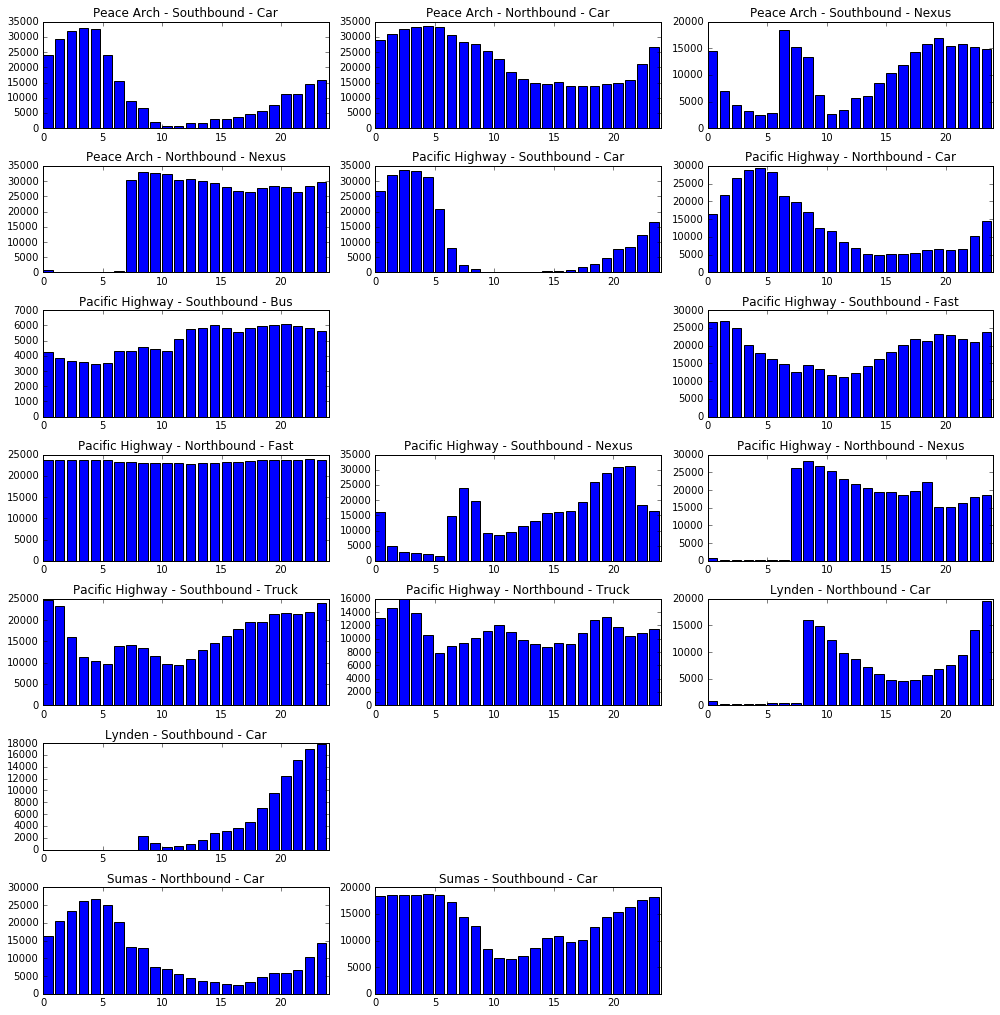

In [309]:
fig = plt.figure(figsize=(14,16))
for i in crossings.index:
    zeros = df[df.index == i]
    if len(zeros) > 0:
        plt.subplot(8, 3, i)
        plt.title(' - '.join(crossings.ix[i][['location_name', 'direction_name', 'lane_name']]))
        plt.xlim([0,24])
        plt.bar(zeros.hour, zeros.wt_count)
        
plt.tight_layout()
plt.show()

### Observations


| Location| Dir | Lane | Notes                                                        |
|---------|---|-------|---------------------------------------------------------------|
| Lynden  | S | Car   | mid-day zeros too high                                        |
| Lynden  | S | Car   | OK                                                            |
| Pacific | S | Bus   | OK                                                            |
| Pacific | N | Car   | mid-day zeros too high                                        |
| Pacific | S | Car   | OK                                                            |
| Pacific | N | Fast  | no structure; highly suspicious                               |
| Pacific | S | Fast  | OK                                                            |
| Pacific | N | Nexus | mid-day zeros too high                                        |
| Pacific | S | Nexus | OK, but data during off hours                                 |
| Pacific | N | Truck | OK                                                            |
| Pacific | S | Truck | OK                                                            |
| Peace   | N | Car   | mid-day zeros too high                                        |
| Peace   | S | Car   | OK                                                            |
| Peace   | N | Nexus | no structure; highly suspicious                               |
| Peace   | S | Nexus | OK, but data during off hours                                 |
| Sumas   | N | Car   | mid-day zeros too high                                        |
| Sumas   | S | Car   | OK                                                            |

* operating hours for Lynden and Peace/Pacific Nexus lanes are evident
    * for forecasting purposes, we can exclude closed hours
    
### Recommended priorities
1. Southbound Cars - Peace Arch
    * following can be added as separate models
    a. Pacific Hwy
    b. Sumas
2. Southbound Cars - Lynden
    * need to solve for off-hours; maybe easy
3. Northbound Cars - Peace Arch
    * need to impute erroneous zero data
4. Northbound Cars - Pacific Hwy
    * need to impute erroneous zero data
5. Northbound Cars - Sumas
    * need to impute erroneous zero data
6. Northbound Cars - Lynden
    * need to impute erroneous zero data